In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [233]:
import warnings
warnings.filterwarnings('ignore')

In [234]:
df = pd.read_csv('diabetes.csv')    

In [235]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [237]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [238]:
df.describe().round(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


* In the variables such as Glucose, BloodPressure, SkinThickness, Insulin, BMI, 0 values probably mean missing data (physiologically it is not possible to be 0).
* All our variables are numeric, we have no categorical variables.
* 25% of SkinThickness is 0. (Data quality problem)

#### Data Visualization    

In [239]:
def distribution_variables(dataframe, max_cols=3):
    num_vars = len(dataframe.columns)  # Değişken sayısı
    num_rows = int(np.ceil(num_vars / max_cols))  # Satır sayısını hesapla

    plt.figure(figsize=(max_cols * 5, num_rows * 4))  # Boyutu otomatik ayarla
    
    for i, column in enumerate(dataframe.columns, 1):
        plt.subplot(num_rows, max_cols, i)
        sns.histplot(data=dataframe, x=column, kde=True)
        plt.title(f'{column} Distribution')

    plt.tight_layout()
    plt.show()

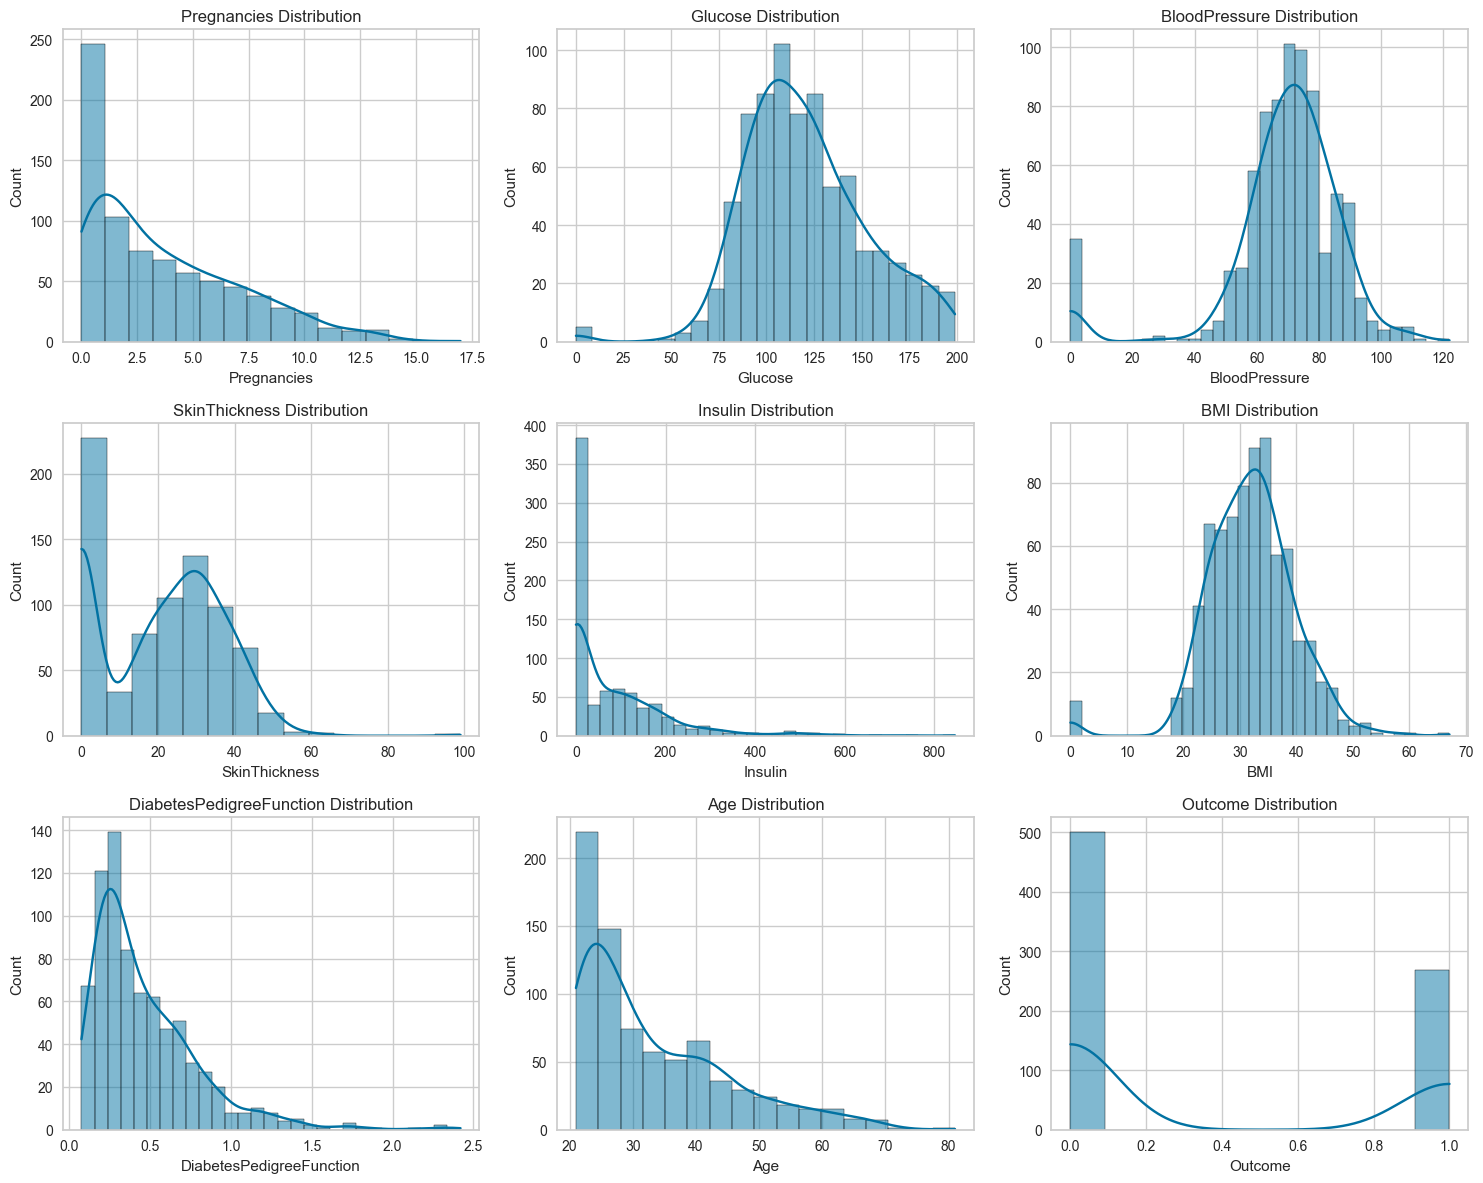

In [240]:
distribution_variables(df,3)

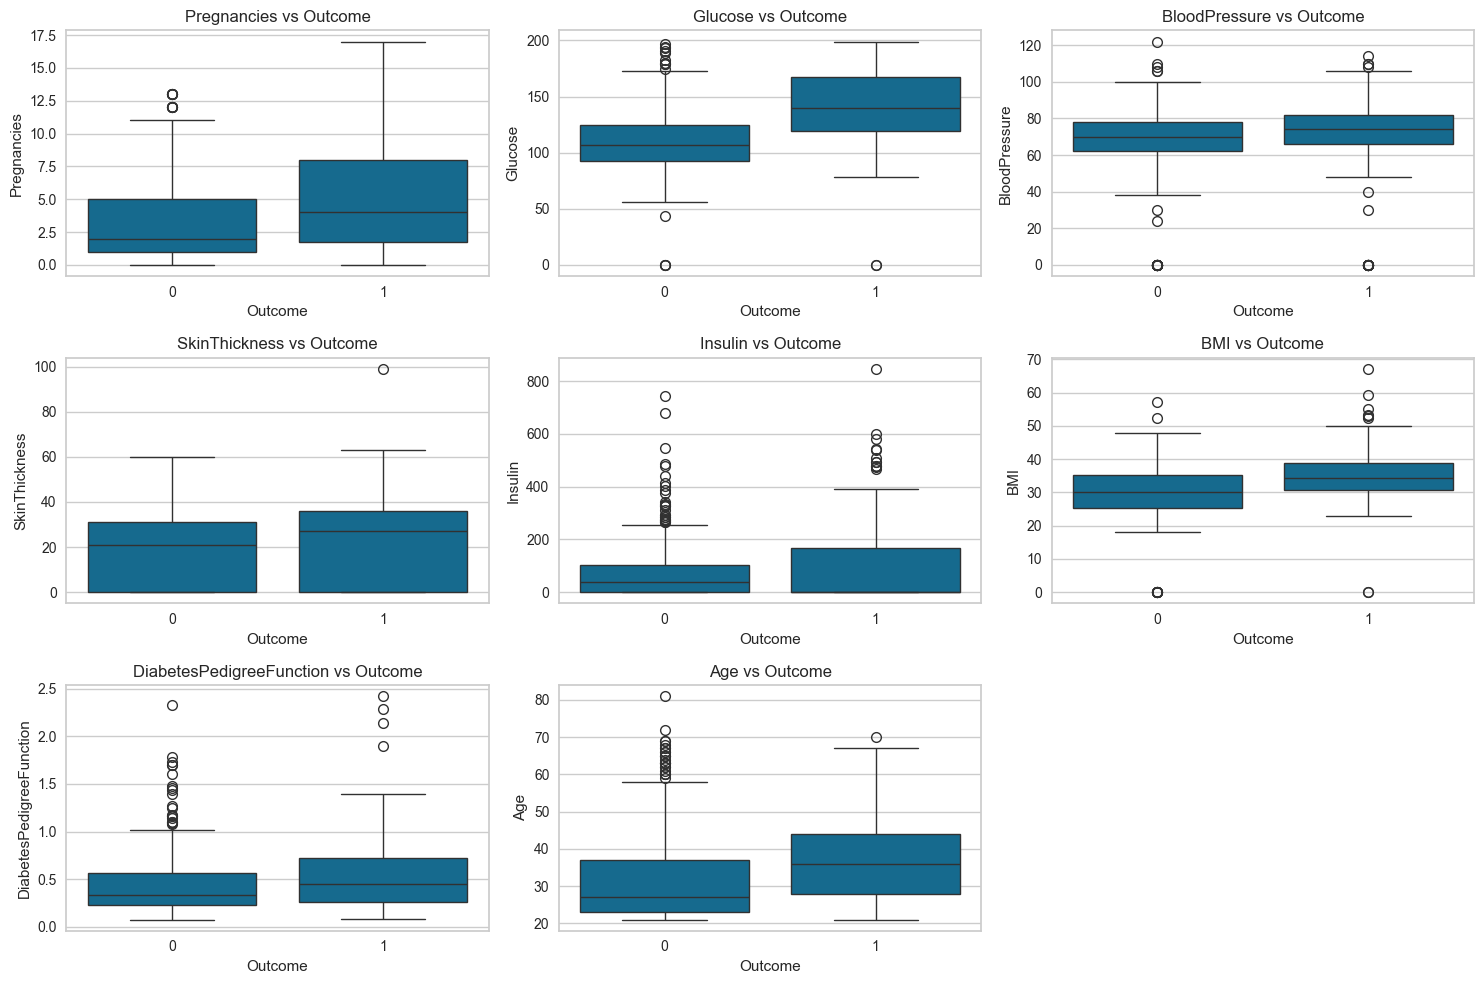

In [241]:
# Variables vs Outcome
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(3 , 3 , i)
    sns.boxplot(data=df, x='Outcome', y=column)
    plt.title(f'{column} vs Outcome')
plt.tight_layout()
plt.show()

#### Preparing the Data

In [242]:
# let's see the zero values in the columns
zeros = {}
for column in df.columns:
    if column != 'Outcome' and column != 'Pregnancies':  # both of these columns can have zeros
        zero_count = (df[column] == 0).sum()
        zero_percentage = (zero_count / len(df)) * 100
        zeros[column] = {'count': zero_count, 'percentage': zero_percentage}

for column, values in zeros.items():
    print(f"{column}: {values['count']} zeros ({values['percentage']:.2f}%)")

Glucose: 5 zeros (0.65%)
BloodPressure: 35 zeros (4.56%)
SkinThickness: 227 zeros (29.56%)
Insulin: 374 zeros (48.70%)
BMI: 11 zeros (1.43%)
DiabetesPedigreeFunction: 0 zeros (0.00%)
Age: 0 zeros (0.00%)


In [243]:
# copy the dataframe
df_clean = df.copy() 

In [244]:
# Use median values for Glucose , BloodPressure , and BMI
# These variables are closer to a normal distribution
for column in ['Glucose', 'BloodPressure', 'BMI']:
    # Calculate the median value for the column where the value is not 0
    median_value = df_clean[df_clean[column] != 0][column].median()
    # Replace the zeros with the median value
    df_clean.loc[df_clean[column] == 0, column] = median_value

In [245]:
# For Insulin and SkinThickness, we will group by Outcome and use median values
# Because these values may vary based on the diabetes status (Outcome: 0 or 1)
for column in ['Insulin', 'SkinThickness']:
    for outcome in [0, 1]:
        # Calculate the median value for Insulin/SkinThickness based on Outcome
        median_value = df_clean[
            (df_clean[column] != 0) & 
            (df_clean['Outcome'] == outcome)
        ][column].median()
        
        # Replace zero values for Insulin/SkinThickness with the computed median value based on Outcome
        df_clean.loc[
            (df_clean[column] == 0) & 
            (df_clean['Outcome'] == outcome), 
            column
        ] = median_value

In [246]:
# Function to handle outliers by applying IQR (Interquartile Range) method
def handle_outliers(df, column):
    # Q1 and Q3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Interquartile Range
    IQR = Q3 - Q1
    
    # lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace values that are above the upper bound with the upper bound value
    df.loc[df[column] > upper_bound, column] = upper_bound
    # Replace values that are below the lower bound with the lower bound value
    df.loc[df[column] < lower_bound, column] = lower_bound
    
    return df

In [247]:
# Process outliers for all columns, excluding 'Outcome' and 'Pregnancies'
# These columns are excluded because they are essential for model prediction
for column in df_clean.columns:
    if column not in ['Outcome', 'Pregnancies']:
        df_clean = handle_outliers(df_clean, column)

In [248]:
df_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.358073,28.848307,133.085938,32.393359,0.458914,33.199870,0.348958
std,3.369578,30.438286,11.697097,7.559161,58.124185,6.667471,0.285596,11.628404,0.476951
min,0.000000,44.000000,40.000000,14.500000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,102.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,102.500000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,169.500000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,104.000000,42.500000,270.000000,50.250000,1.200000,66.500000,1.000000


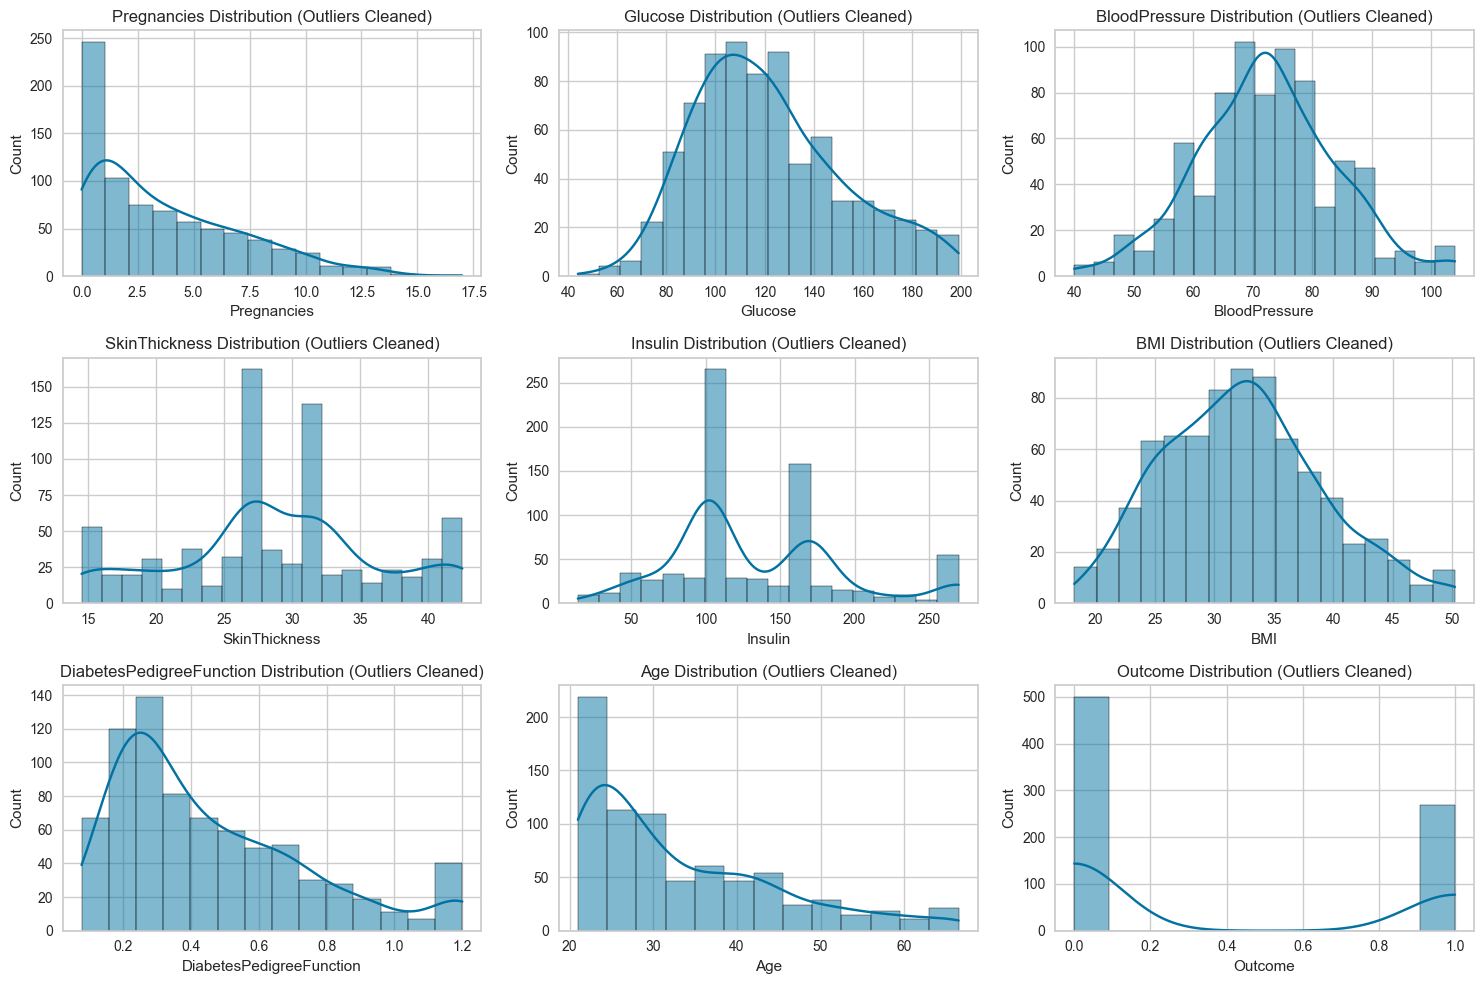

In [249]:
# 1. Distribution analysis of each variable
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_clean.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df_clean, x=column, kde=True)
    plt.title(f'{column} Distribution (Outliers Cleaned)')
plt.tight_layout()
plt.show()


In [250]:
print(f"Insulin Skewness Value : {df_clean['Insulin'].skew():.2f}")

Insulin Skewness Value : 0.73


In [251]:
df_clean['Insulin_log'] = np.log1p(df_clean['Insulin'])  # preventing 0 values with log(1+x)

In [252]:
print(f"Insulin Skewness Value for log : {df_clean['Insulin_log'].skew():.2f}")

Insulin Skewness Value for log : -0.78


In [253]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
df_clean['Insulin_quantile'] = qt.fit_transform(df_clean[['Insulin']])

In [254]:
joblib.dump(qt, 'quantile_transformer.pkl')


['quantile_transformer.pkl']

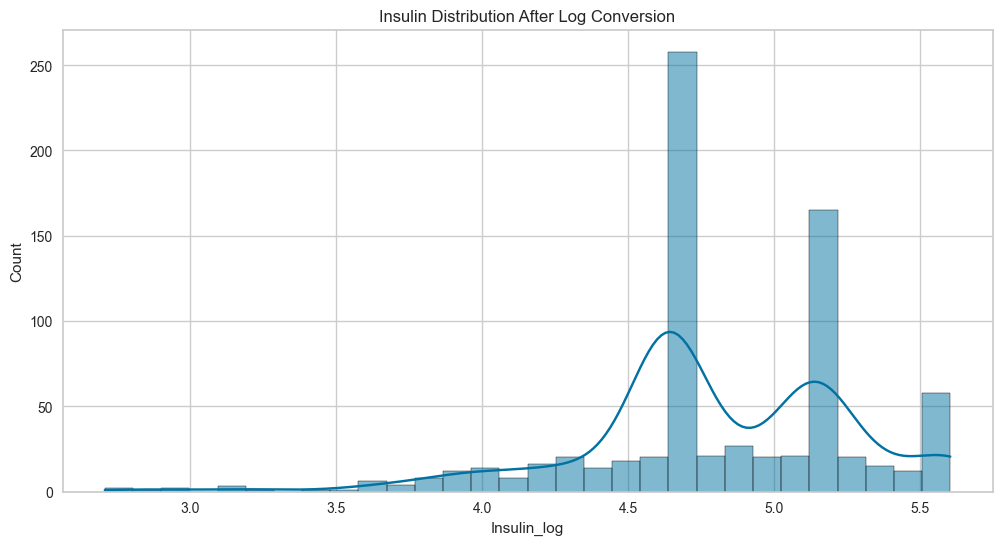

In [255]:
# Visualise the new distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_clean["Insulin_log"], kde=True, bins=30)
plt.title("Insulin Distribution After Log Conversion")
plt.show()

In [256]:
print(f"Insulin Skewness Value for quantiled: {df_clean['Insulin_quantile'].skew():.2f}")

Insulin Skewness Value for quantiled: 1.79


In [257]:
def hist_plot_column(dataframe, column, title):
    plt.figure(figsize=(12, 6))
    sns.histplot(data=dataframe, x=column, kde=True)
    plt.title(title)
    plt.show()

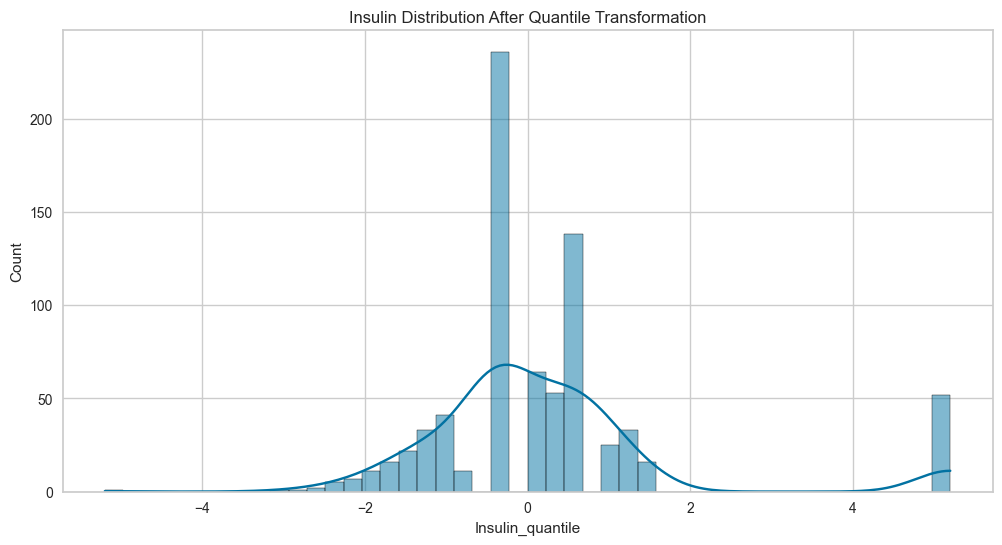

In [258]:
hist_plot_column(df_clean, 'Insulin_quantile', 'Insulin Distribution After Quantile Transformation')

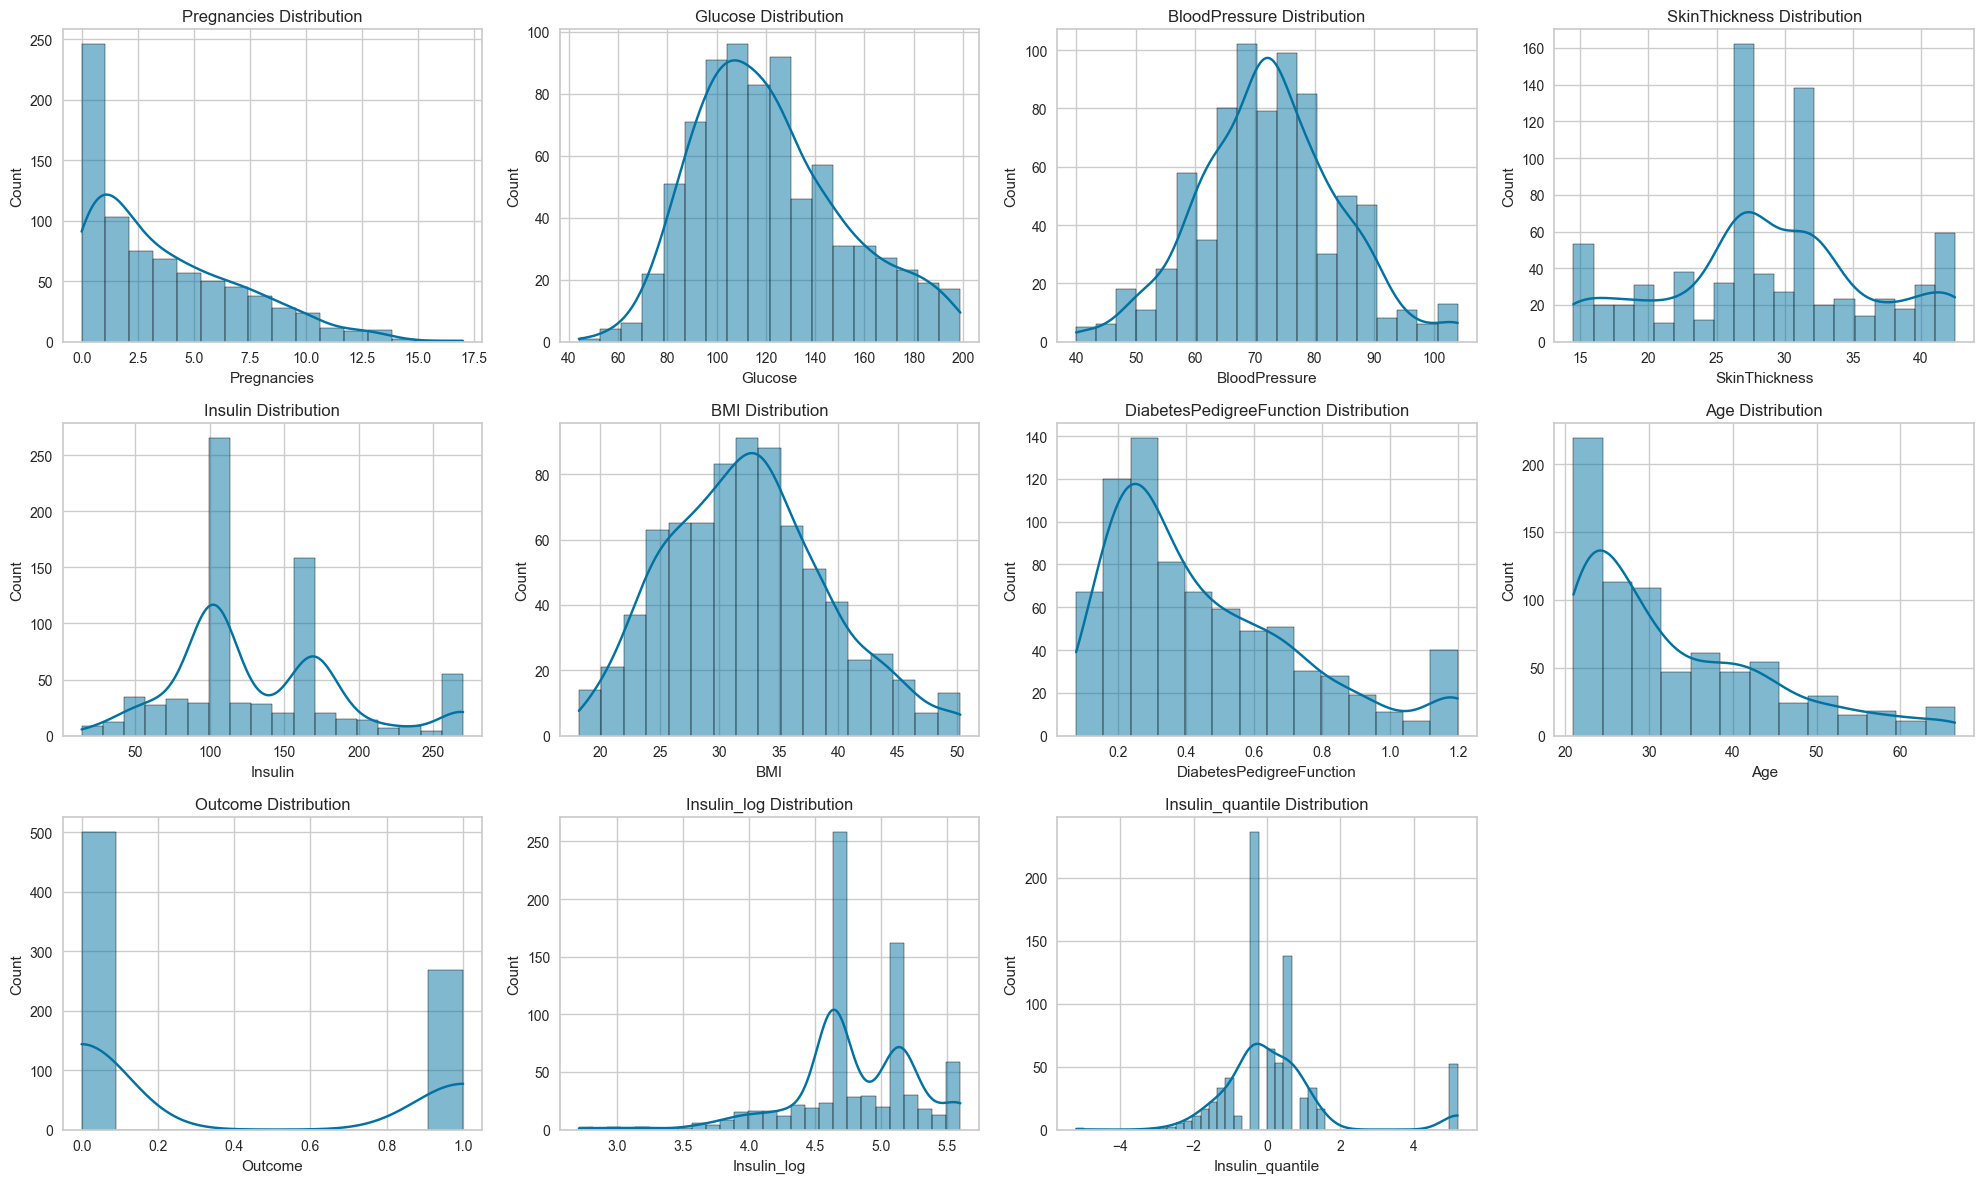

In [259]:
distribution_variables(df_clean,4)

In [260]:
df_clean.drop(['Insulin', 'Insulin_log'], axis=1, inplace=True)

In [261]:
df_clean.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_quantile
0,6,148,72,35.0,33.6,0.627,50.0,1,0.663249
1,1,85,66,29.0,26.6,0.351,31.0,0,-0.385144
2,8,183,64,32.0,23.3,0.672,32.0,1,0.663249
3,1,89,66,23.0,28.1,0.167,21.0,0,-0.933199
4,0,137,40,35.0,43.1,1.200,33.0,1,0.395725


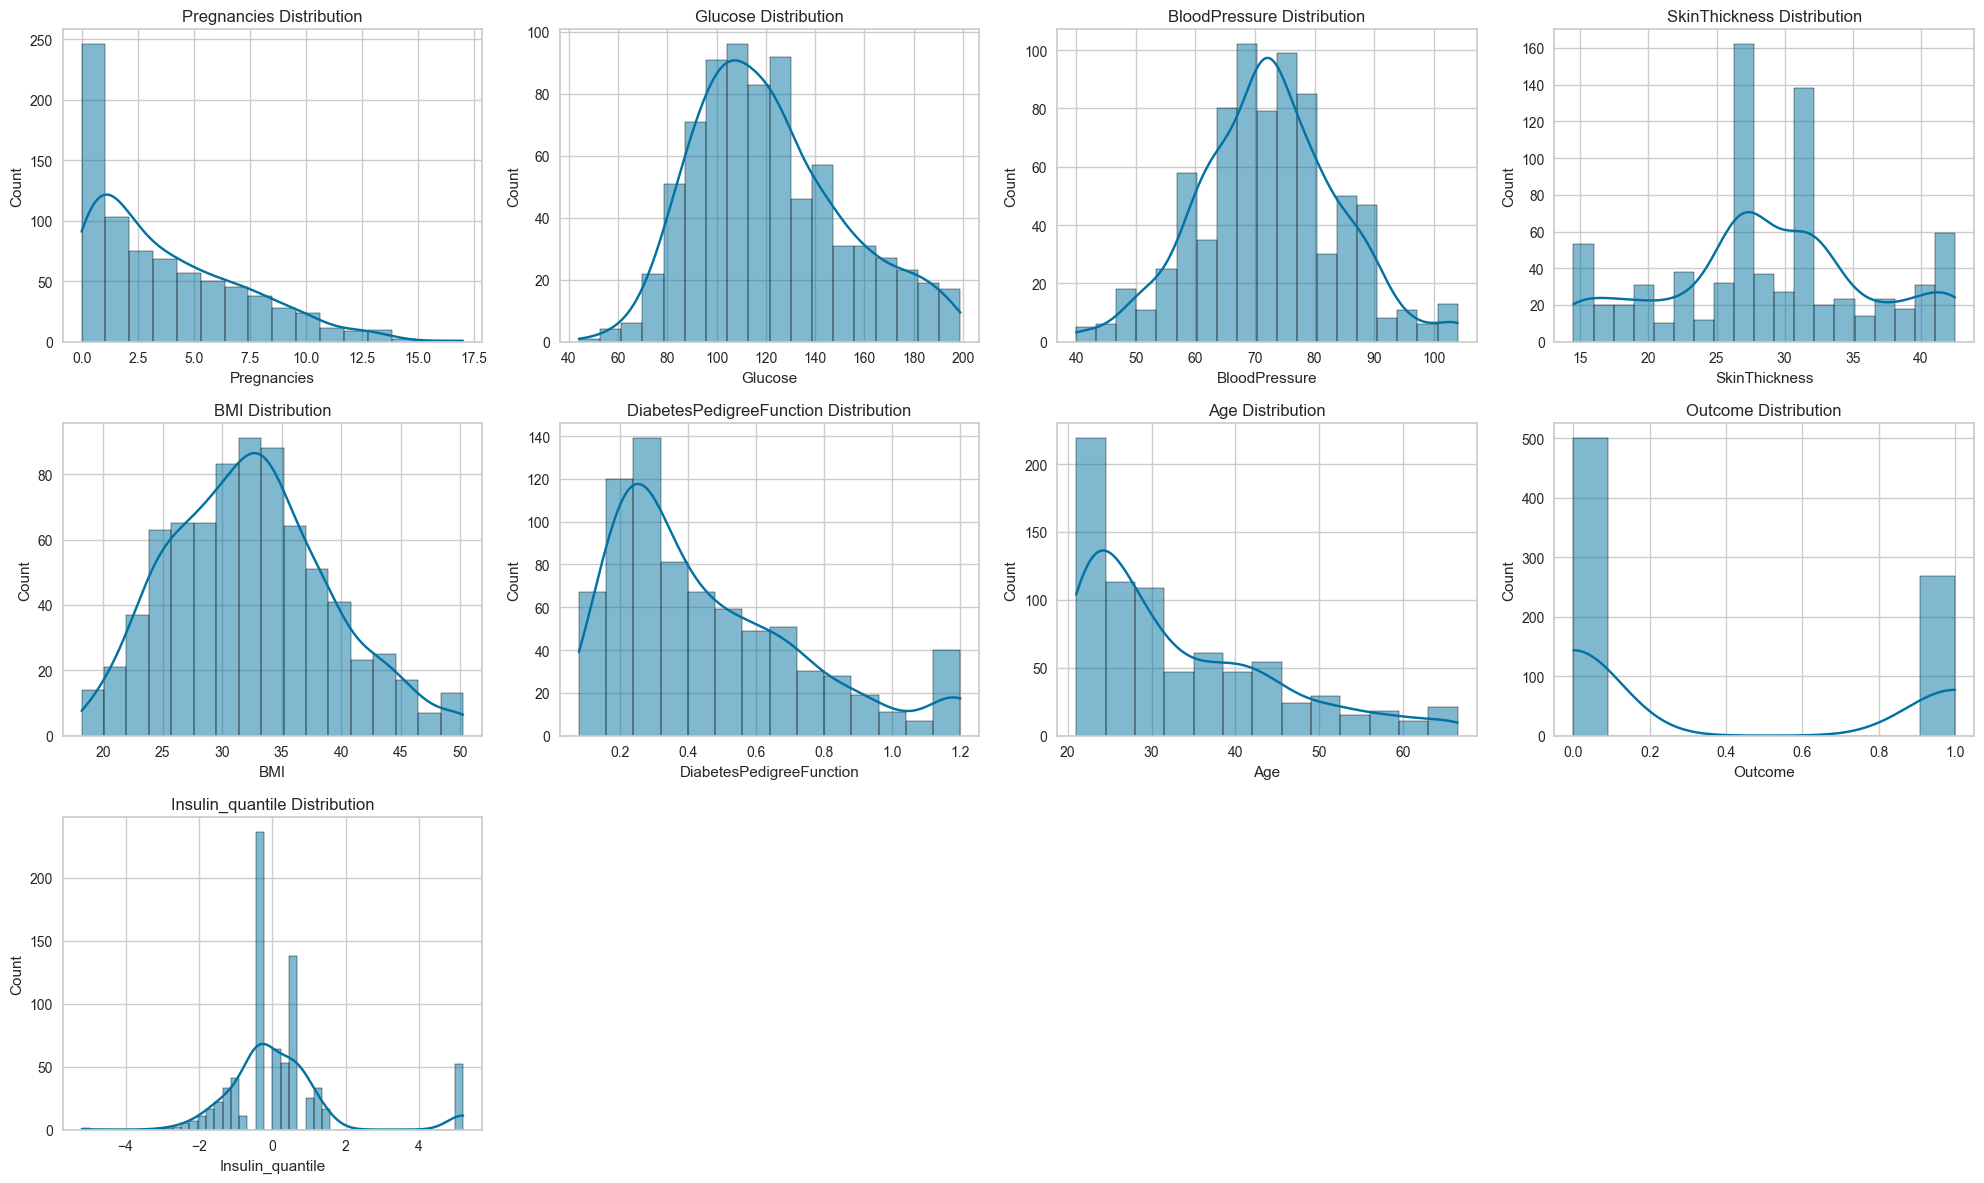

In [262]:
distribution_variables(df_clean,4)

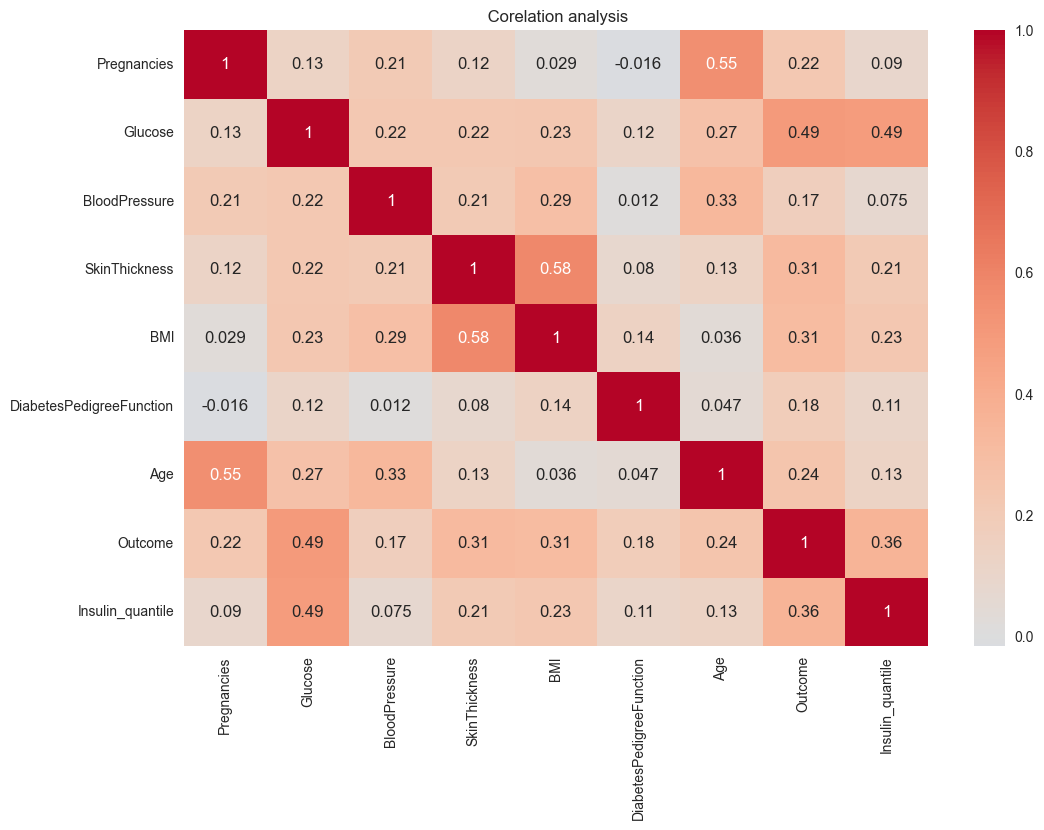

In [263]:
# 2. Corelation analysis and heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', center=0)
plt.title(' Corelation analysis')
plt.show()

In [264]:
df_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_quantile
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.358073,28.848307,32.393359,0.458914,33.199870,0.348958,0.219975
std,3.369578,30.438286,11.697097,7.559161,6.667471,0.285596,11.628404,0.476951,1.587677
min,0.000000,44.000000,40.000000,14.500000,18.200000,0.078000,21.000000,0.000000,-5.199338
25%,1.000000,99.750000,64.000000,25.000000,27.500000,0.243750,24.000000,0.000000,-0.385144
50%,3.000000,117.000000,72.000000,28.000000,32.300000,0.372500,29.000000,0.000000,-0.385144
75%,6.000000,140.250000,80.000000,32.000000,36.600000,0.626250,41.000000,1.000000,0.663249
max,17.000000,199.000000,104.000000,42.500000,50.250000,1.200000,66.500000,1.000000,5.199338


In [265]:
df_clean.drop(["BloodPressure"], axis=1, inplace=True)

##### Log Transformation

In [266]:
# 1. DiabetesPedigreeFunction için log dönüşümü
df_clean['DiabetesPedigreeFunction_log'] = np.log1p(df_clean['DiabetesPedigreeFunction'])


In [267]:
df_clean.head()

,Pregnancies,Glucose,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_quantile,DiabetesPedigreeFunction_log
0,6,148,35.0,33.6,0.627,50.0,1,0.663249,0.486738
1,1,85,29.0,26.6,0.351,31.0,0,-0.385144,0.300845
2,8,183,32.0,23.3,0.672,32.0,1,0.663249,0.514021
3,1,89,23.0,28.1,0.167,21.0,0,-0.933199,0.154436
4,0,137,35.0,43.1,1.200,33.0,1,0.395725,0.788457


✅ Sayısal değişkenleri ölçeklendir:

In [268]:
from sklearn.preprocessing import StandardScaler


In [269]:
scaler = StandardScaler()
num_cols = ['Glucose', 'SkinThickness', 'BMI', 'Age']
df_clean[num_cols] = scaler.fit_transform(df_clean[num_cols])



In [270]:
# Scaler'ı kaydet (DİKKAT: Feature selection ÖNCESİ)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [271]:
import pickle

with open("scaler.pkl", "rb") as f:
    data = pickle.load(f)

print(type(data))  # Veri türünü kontrol et



<class 'numpy.ndarray'>


In [272]:
if hasattr(data, "feature_names_in_"):
    print(data.feature_names_in_)

In [273]:
print(data.keys() if isinstance(data, dict) else data)


['Glucose' 'SkinThickness' 'BMI' 'Age']


✅ Kategorik değişkenleri One-Hot Encoding ile sayısallaştır:

In [274]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Pregnancies                   768 non-null    int64  
 1   Glucose                       768 non-null    float64
 2   SkinThickness                 768 non-null    float64
 3   BMI                           768 non-null    float64
 4   DiabetesPedigreeFunction      768 non-null    float64
 5   Age                           768 non-null    float64
 6   Outcome                       768 non-null    int64  
 7   Insulin_quantile              768 non-null    float64
 8   DiabetesPedigreeFunction_log  768 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 54.1 KB


In [275]:
df_clean.describe()

,Pregnancies,Glucose,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_quantile,DiabetesPedigreeFunction_log
count,768.000000,7.680000e+02,7.680000e+02,7.680000e+02,768.000000,7.680000e+02,768.000000,768.000000,768.000000
mean,3.845052,4.625929e-18,-1.595946e-16,-4.417762e-16,0.458914,2.220446e-16,0.348958,0.219975,0.360172
std,3.369578,1.000652e+00,1.000652e+00,1.000652e+00,0.285596,1.000652e+00,0.476951,1.587677,0.183537
min,0.000000,-2.552931e+00,-1.899372e+00,-2.130134e+00,0.078000,-1.049828e+00,0.000000,-5.199338,0.075107
25%,1.000000,-7.201630e-01,-5.094236e-01,-7.343936e-01,0.243750,-7.916706e-01,0.000000,-0.385144,0.218131
50%,3.000000,-1.530732e-01,-1.122956e-01,-1.401134e-02,0.372500,-3.614087e-01,0.000000,-0.385144,0.316633
75%,6.000000,6.112653e-01,4.172086e-01,6.313311e-01,0.626250,6.712197e-01,1.000000,0.663249,0.486277
max,17.000000,2.542658e+00,1.807157e+00,2.679918e+00,1.200000,2.865555e+00,1.000000,5.199338,0.788457


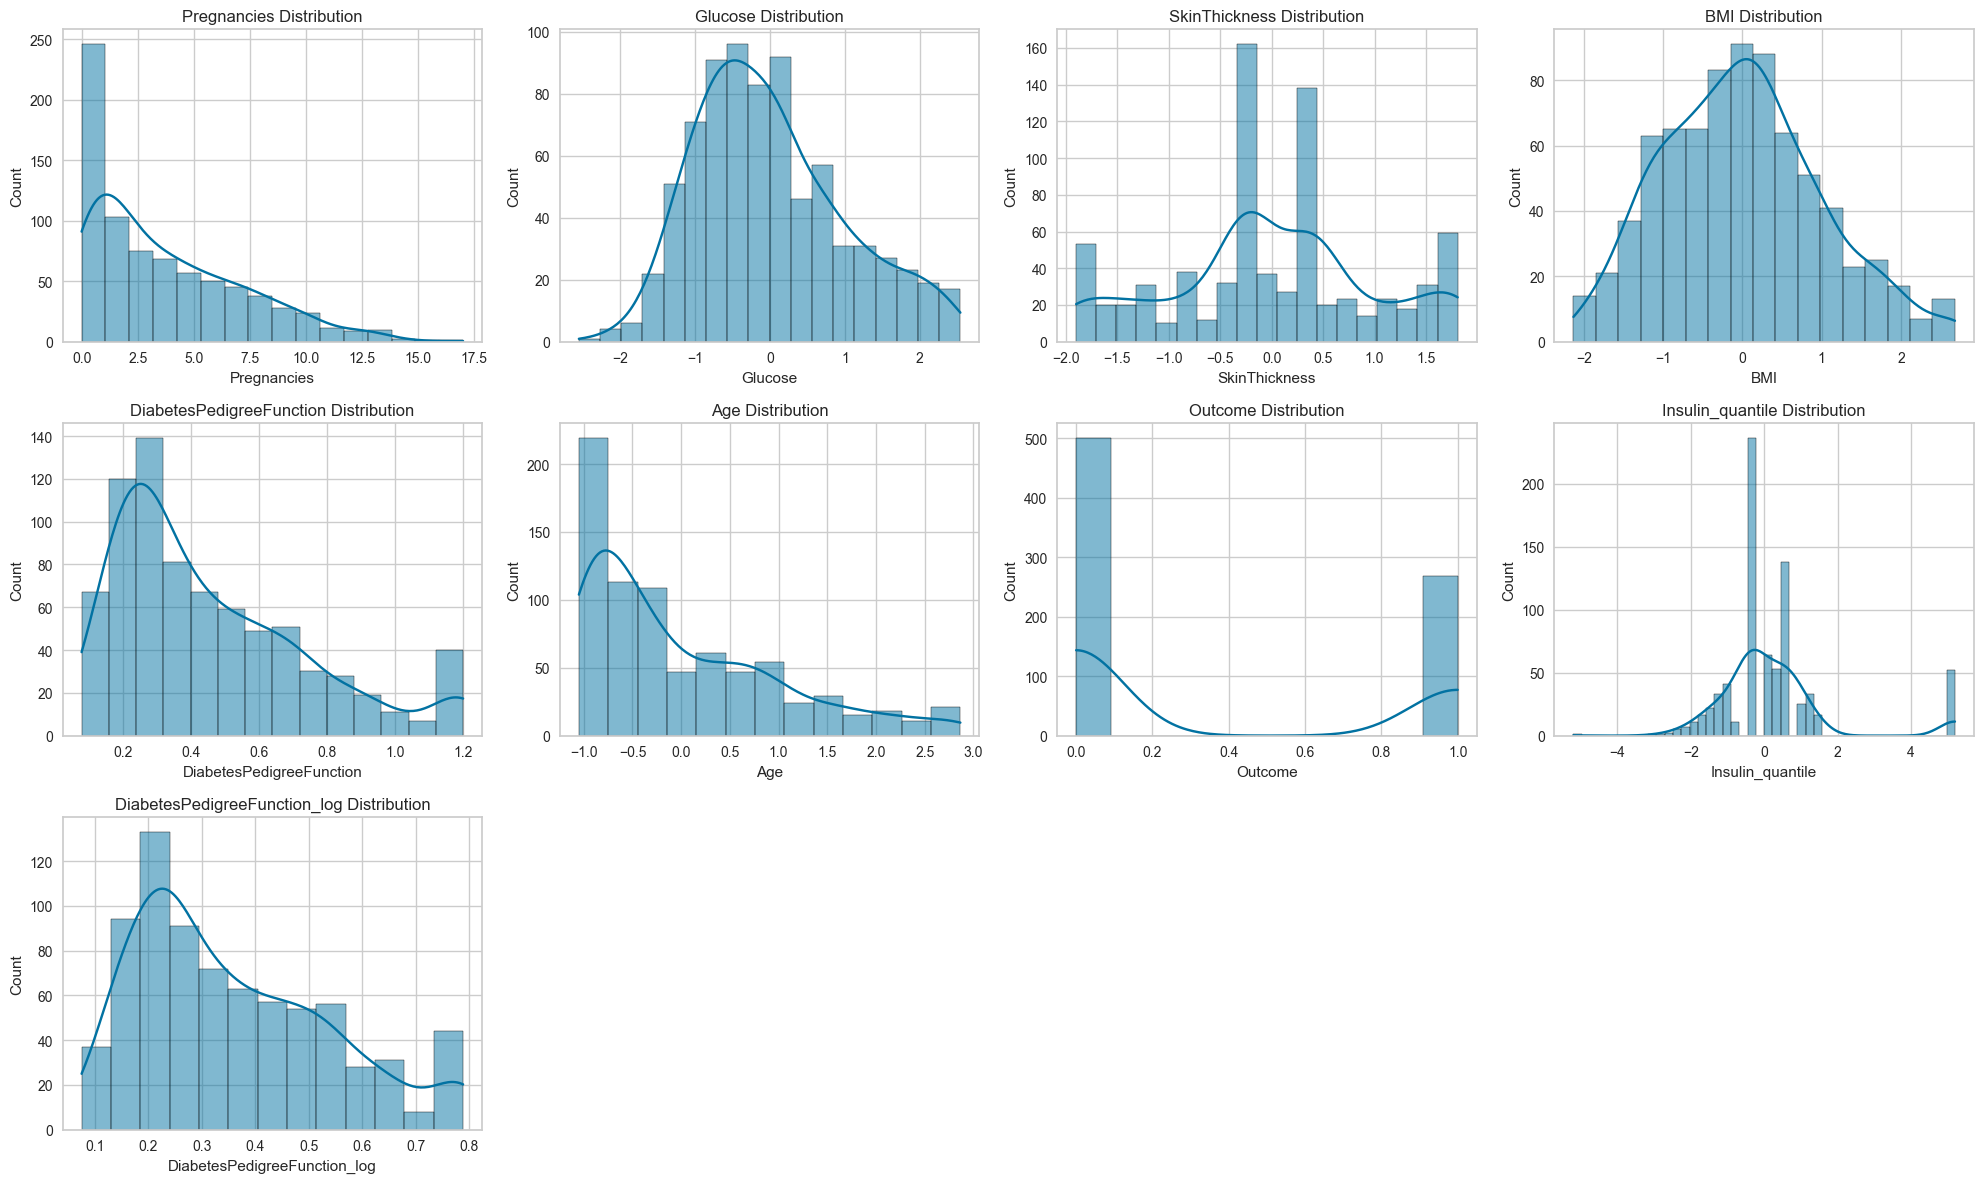

In [276]:
distribution_variables(df_clean,4)

Feature Selection

In [277]:
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold


In [278]:
df_fs= df_clean.copy()

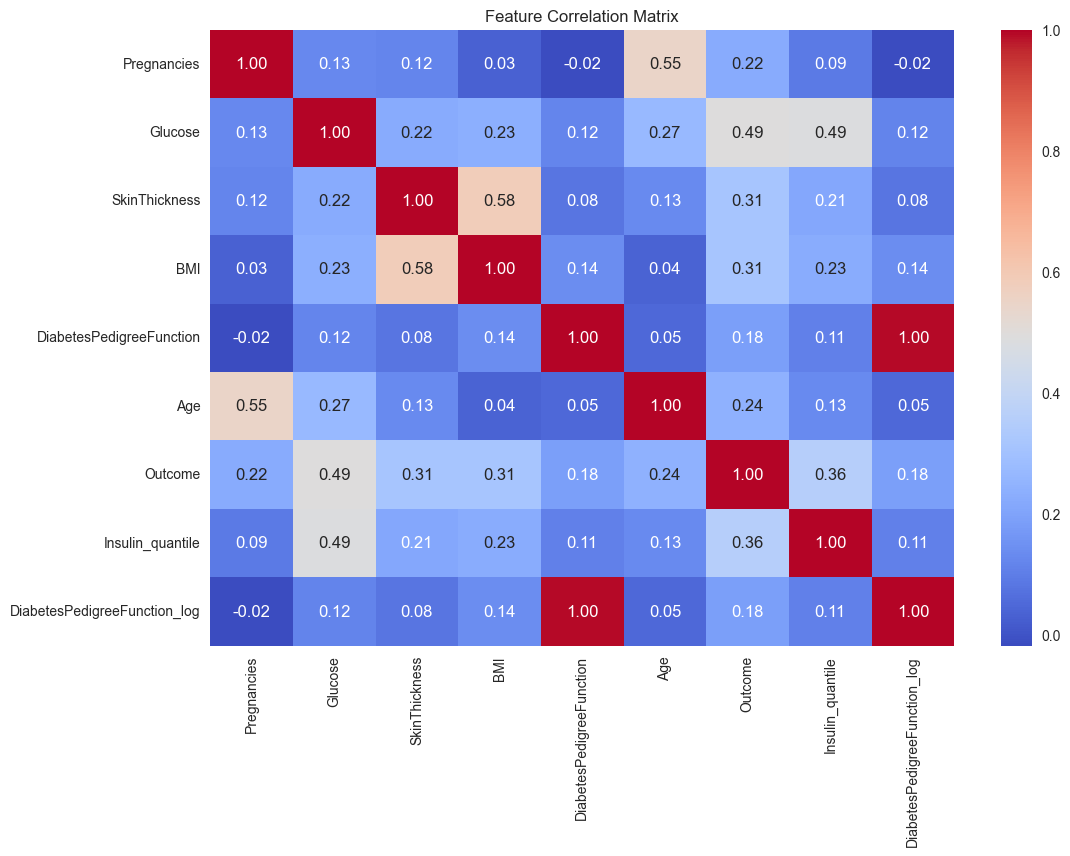

In [279]:
# Corelation analysis
plt.figure(figsize=(12,8))
sns.heatmap(df_fs.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [280]:
# mutual information
X = df_fs.drop(columns=['Outcome'])  # Hedef değişkeni çıkartıyoruz
y = df_fs['Outcome']
mi_scores = mutual_info_classif(X, y, random_state=42)


In [281]:
# mı scores
mi_scores_df = pd.DataFrame({"Feature": X.columns, "MI Score": mi_scores})
mi_scores_df = mi_scores_df.sort_values(by="MI Score", ascending=False)
print(mi_scores_df)

                        Feature  MI Score
6              Insulin_quantile  0.361451
2                 SkinThickness  0.126772
1                       Glucose  0.117733
3                           BMI  0.080099
0                   Pregnancies  0.060985
5                           Age  0.055222
7  DiabetesPedigreeFunction_log  0.010416
4      DiabetesPedigreeFunction  0.005709


In [282]:
selector = VarianceThreshold(threshold=0.01)  # %1'den düşük varyansı olanları çıkar
X_new = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]
print("Seçilen Özellikler:", selected_features)

Seçilen Özellikler: Index(['Pregnancies', 'Glucose', 'SkinThickness', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Insulin_quantile',
       'DiabetesPedigreeFunction_log'],
      dtype='object')


In [283]:
# çıkarılacak Özellikler
remove_features = [
    'DiabetesPedigreeFunction', 'DiabetesPedigreeFunction_log',
]

#Güncellenmiş DataFrame
df_fselected = df_fs.drop(columns=remove_features)

print("Yeni Feature Set:", df_fselected.columns)


Yeni Feature Set: Index(['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'Age', 'Outcome',
       'Insulin_quantile'],
      dtype='object')


In [284]:
df_fselected.head()

,Pregnancies,Glucose,SkinThickness,BMI,Age,Outcome,Insulin_quantile
0,6,0.866045,0.814337,0.181092,1.445691,1,0.663249
1,1,-1.205066,0.020080,-0.869465,-0.189304,0,-0.385144
2,8,2.016662,0.417209,-1.364728,-0.103252,1,0.663249
3,1,-1.073567,-0.774176,-0.644346,-1.049828,0,-0.933199
4,0,0.504422,0.814337,1.606849,-0.017199,1,0.395725


In [285]:
df_fselected.to_csv('diabetes_cleaned.csv', index=False)

In [286]:
df_model = df_fselected.copy()

In [287]:
# Gerekli kütüphaneleri import edelim
from pycaret.classification import *
# İlk olarak setup işlemini gerçekleştirelim
clf = setup(data=df_model, 
            target='Outcome',
            session_id=123,
            normalize=True,                    # Sayısal değişkenleri normalize et
            transformation=True,               # Gerekli transformasyonları uygula
            remove_multicollinearity=True,     # Yüksek korelasyonlu özellikleri ele al
            multicollinearity_threshold=0.95,  # Korelasyon eşiği
            fold=5)                           # 5-fold cross validation

,Description,Value
0,Session id,123
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(768, 7)"
4,Transformed data shape,"(768, 7)"
5,Transformed train set shape,"(537, 7)"
6,Transformed test set shape,"(231, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [288]:
print(df_model['Outcome'].value_counts(normalize=True))


Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [289]:
# Tüm modelleri karşılaştır
best_models = compare_models(n_select=3,    # En iyi 3 modeli seç
                           sort='AUC',      # AUC metriğine göre sırala çünkü dengesiz bir veri seti var
                           verbose=True)     # Detaylı çıktı göster

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8753,0.9458,0.7866,0.8444,0.8136,0.7202,0.7220,0.0680
xgboost,Extreme Gradient Boosting,0.8864,0.9451,0.8026,0.8659,0.8304,0.7455,0.7491,0.1280
rf,Random Forest Classifier,0.8827,0.9417,0.8024,0.8562,0.8270,0.7385,0.7408,0.0820
gbc,Gradient Boosting Classifier,0.8678,0.9361,0.7868,0.8304,0.8044,0.7052,0.7091,0.0560
et,Extra Trees Classifier,0.8547,0.9331,0.7700,0.8066,0.7870,0.6769,0.6782,0.0820
ada,Ada Boost Classifier,0.8659,0.9294,0.8080,0.8102,0.8064,0.7042,0.7068,0.0580
knn,K Neighbors Classifier,0.8380,0.8953,0.7275,0.7946,0.7560,0.6356,0.6400,0.5760
nb,Naive Bayes,0.7782,0.8523,0.6994,0.6743,0.6854,0.5144,0.5157,0.0320
qda,Quadratic Discriminant Analysis,0.7856,0.8508,0.6457,0.7068,0.6727,0.5145,0.5170,0.0480
dt,Decision Tree Classifier,0.8567,0.8441,0.8026,0.7912,0.7960,0.6857,0.6865,0.0260


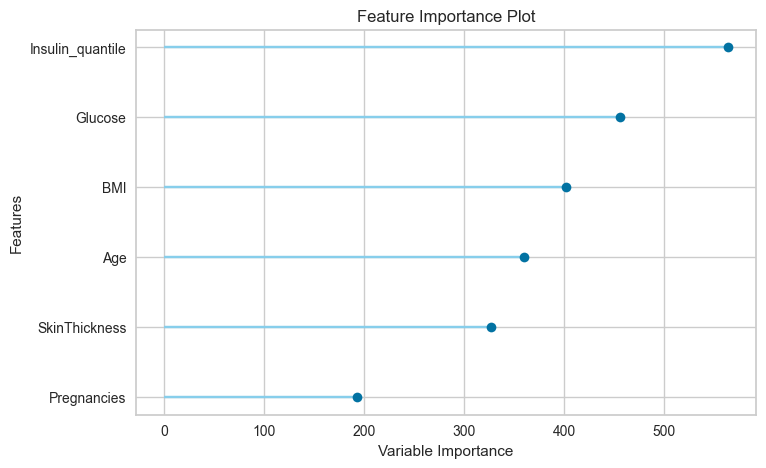

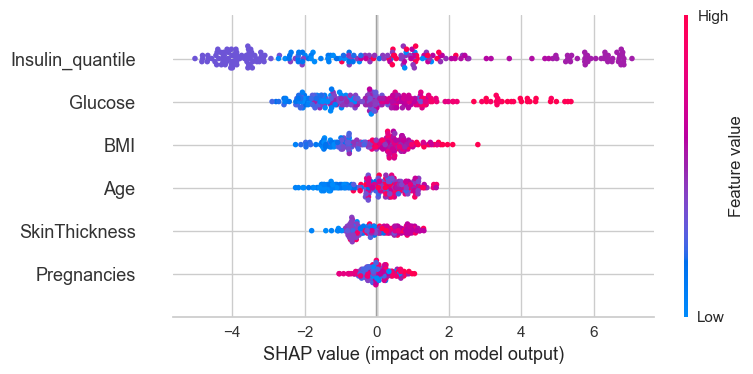

In [290]:
import shap

# En iyi model için feature importance analizi
plot_model(best_models[0], plot='feature')

# SHAP değerleri ile detaylı analiz
interpret_model(best_models[0], plot='summary')

In [291]:
tuned_model = tune_model(best_models[0], 
                         optimize='AUC', 
                         n_iter=50, 
                         search_library='optuna', 
                         verbose=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9074,0.9662,0.8421,0.8889,0.8649,0.7945,0.7952
1,0.8426,0.9571,0.6053,0.9200,0.7302,0.6256,0.6529
2,0.8879,0.9409,0.7838,0.8788,0.8286,0.7456,0.7483
3,0.9065,0.9753,0.8649,0.8649,0.8649,0.7934,0.7934
4,0.8598,0.9413,0.8378,0.7750,0.8052,0.6960,0.6973
Mean,0.8808,0.9562,0.7868,0.8655,0.8187,0.7310,0.7374
Std,0.0258,0.0136,0.0946,0.0488,0.0498,0.0640,0.0554


In [292]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split


In [293]:

# Veriyi hazırlayalım
X = df_model.drop('Outcome', axis=1)
y = df_model['Outcome']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TPOT sınıflandırıcısını oluşturalım
tpot_classifier = TPOTClassifier(
    generations=10,               # Genetik algoritmanın kaç nesil çalışacağı
    population_size=50,          # Her nesildeki pipeline sayısı
    cv=5,                        # Cross-validation fold sayısı
    random_state=42,
    verbosity=2,                 # Detaylı çıktı için
    scoring='roc_auc',           # Optimizasyon metriği
    n_jobs=-1                    # Tüm CPU çekirdeklerini kullan
)

# TPOT'u eğitelim
tpot_classifier.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9495240316913443

Generation 2 - Current best internal CV score: 0.9516965567450064

Generation 3 - Current best internal CV score: 0.9516965567450064

Generation 4 - Current best internal CV score: 0.9516965567450064

Generation 5 - Current best internal CV score: 0.952712323804055

Generation 6 - Current best internal CV score: 0.952712323804055

Generation 7 - Current best internal CV score: 0.9537026270456502

Generation 8 - Current best internal CV score: 0.9558669148107132

Generation 9 - Current best internal CV score: 0.9558669148107132

Generation 10 - Current best internal CV score: 0.958483347688774

Best pipeline: RandomForestClassifier(XGBClassifier(input_matrix, learning_rate=0.01, max_depth=6, min_child_weight=16, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0), bootstrap=False, criterion=entropy, max_features=0.45, min_samples_leaf=7, min_samples_split=4, n_estimators=100)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=10,
               log_file=None, max_eval_time_mins=5, max_time_mins=None,
               memory=None, mutation_rate=0.9, n_jobs=-1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=50,
               random_state=42, scoring='roc_auc', subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [294]:
# Test seti üzerinde performansı değerlendirelim
print(f"Accuracy : {tpot_classifier.score(X_test, y_test)}")

# En iyi pipeline'ı görelim
print("\nEn İyi Pipeline:")
print(tpot_classifier.fitted_pipeline_)

# En iyi pipeline'ı Python koduna dönüştürüp kaydedelim
tpot_classifier.export('tpot_diabetes_pipeline.py')

Accuracy : 0.9369146005509641

En İyi Pipeline:
Pipeline(memory=None,
         steps=[('stackingestimator',
                 StackingEstimator(estimator=XGBClassifier(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                     

In [295]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [296]:
y_pred_pycaret = predict_model(tuned_model, data=df_model)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9115,0.9755,0.8396,0.9000,0.8687,0.8020,0.8032


[LightGBM] [Warning] feature_fraction is set=0.6143485301450693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6143485301450693
[LightGBM] [Warning] bagging_fraction is set=0.726479039862914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.726479039862914
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6143485301450693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6143485301450693
[LightGBM] [Warning] bagging_fraction is set=0.726479039862914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.726479039862914
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [297]:
# Assuming df_test is the test dataset you are using for prediction
y_test_pycaret = df_model['Outcome']

# Now, proceed with evaluating the PyCaret model's performance
y_pred_pycaret_labels = y_pred_pycaret['prediction_label']

# Calculate metrics for PyCaret model using the correct column for predictions
conf_matrix_pycaret = confusion_matrix(y_test_pycaret, y_pred_pycaret_labels)
accuracy_pycaret = accuracy_score(y_test_pycaret, y_pred_pycaret_labels)
precision_pycaret = precision_score(y_test_pycaret, y_pred_pycaret_labels)
recall_pycaret = recall_score(y_test_pycaret, y_pred_pycaret_labels)
f1_pycaret = f1_score(y_test_pycaret, y_pred_pycaret_labels)
roc_auc_pycaret = roc_auc_score(y_test_pycaret, y_pred_pycaret_labels)

# Print the metrics
print(f"PyCaret Model Performance:\n")
print(f"Accuracy: {accuracy_pycaret}")
print(f"Precision: {precision_pycaret}")
print(f"Recall: {recall_pycaret}")
print(f"F1-Score: {f1_pycaret}")
print(f"ROC AUC: {roc_auc_pycaret}")


PyCaret Model Performance:

Accuracy: 0.9114583333333334
Precision: 0.9
Recall: 0.8395522388059702
F1-Score: 0.8687258687258688
ROC AUC: 0.8947761194029851


In [298]:
# Predict with TPOT
y_pred_tpot = tpot_classifier.predict(X_test)


In [299]:
# Import necessary metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate metrics for TPOT model
conf_matrix_tpot = confusion_matrix(y_test, y_pred_tpot)
accuracy_tpot = accuracy_score(y_test, y_pred_tpot)
precision_tpot = precision_score(y_test, y_pred_tpot)
recall_tpot = recall_score(y_test, y_pred_tpot)
f1_tpot = f1_score(y_test, y_pred_tpot)
roc_auc_tpot = roc_auc_score(y_test, y_pred_tpot)

# Print the metrics
print(f"TPOT Model Performance:\n")
print(f"Confusion Matrix:\n{conf_matrix_tpot}")
print(f"Accuracy: {accuracy_tpot}")
print(f"Precision: {precision_tpot}")
print(f"Recall: {recall_tpot}")
print(f"F1-Score: {f1_tpot}")
print(f"ROC AUC: {roc_auc_tpot}")


TPOT Model Performance:

Confusion Matrix:
[[87 12]
 [ 8 47]]
Accuracy: 0.8701298701298701
Precision: 0.7966101694915254
Recall: 0.8545454545454545
F1-Score: 0.8245614035087719
ROC AUC: 0.8666666666666666


In [300]:
# Make predictions using TPOT
y_pred_tpot = tpot_classifier.predict(X_test)

# Calculate metrics for PyCaret model
y_pred_pycaret_labels = y_pred_pycaret['prediction_label']
conf_matrix_pycaret = confusion_matrix(y_test_pycaret, y_pred_pycaret_labels)
accuracy_pycaret = accuracy_score(y_test_pycaret, y_pred_pycaret_labels)
precision_pycaret = precision_score(y_test_pycaret, y_pred_pycaret_labels)
recall_pycaret = recall_score(y_test_pycaret, y_pred_pycaret_labels)
f1_pycaret = f1_score(y_test_pycaret, y_pred_pycaret_labels)
roc_auc_pycaret = roc_auc_score(y_test_pycaret, y_pred_pycaret_labels)

# Calculate metrics for TPOT model
conf_matrix_tpot = confusion_matrix(y_test, y_pred_tpot)
accuracy_tpot = accuracy_score(y_test, y_pred_tpot)
precision_tpot = precision_score(y_test, y_pred_tpot)
recall_tpot = recall_score(y_test, y_pred_tpot)
f1_tpot = f1_score(y_test, y_pred_tpot)
roc_auc_tpot = roc_auc_score(y_test, y_pred_tpot)

# Print the metrics for PyCaret model
print(f"PyCaret Model Performance:\n")
print(f"Confusion Matrix:\n{conf_matrix_pycaret}")
print(f"Accuracy: {accuracy_pycaret}")
print(f"Precision: {precision_pycaret}")
print(f"Recall: {recall_pycaret}")
print(f"F1-Score: {f1_pycaret}")
print(f"ROC AUC: {roc_auc_pycaret}")

# Print the metrics for TPOT model
print(f"\nTPOT Model Performance:\n")
print(f"Confusion Matrix:\n{conf_matrix_tpot}")
print(f"Accuracy: {accuracy_tpot}")
print(f"Precision: {precision_tpot}")
print(f"Recall: {recall_tpot}")
print(f"F1-Score: {f1_tpot}")
print(f"ROC AUC: {roc_auc_tpot}")


PyCaret Model Performance:

Confusion Matrix:
[[475  25]
 [ 43 225]]
Accuracy: 0.9114583333333334
Precision: 0.9
Recall: 0.8395522388059702
F1-Score: 0.8687258687258688
ROC AUC: 0.8947761194029851

TPOT Model Performance:

Confusion Matrix:
[[87 12]
 [ 8 47]]
Accuracy: 0.8701298701298701
Precision: 0.7966101694915254
Recall: 0.8545454545454545
F1-Score: 0.8245614035087719
ROC AUC: 0.8666666666666666


In [301]:
from pycaret.classification import save_model

# Modeli export et
save_model(tuned_model, 'diabetes_model')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Pregnancies', 'Glucose',
                                              'SkinThickness', 'BMI', 'Age',
                                              'Insulin_quantile'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerW...
                                 importance_type='split',
                           

In [302]:
from pycaret.classification import load_model, predict_model


In [303]:
# Modeli yükleyelim
loaded_model = load_model('diabetes_model')


Transformation Pipeline and Model Successfully Loaded


In [315]:
import joblib
import pandas as pd

# Test için ham insulin değerleri
test_data_raw = pd.DataFrame({
    'Pregnancies': [6, 6, 1],
    'Glucose': [70, 70, 70],
    'SkinThickness': [35, 35, 32],
    'BMI': [33.6, 33.6, 23.3],
    'Age': [50, 50, 28],
    'Insulin': [120, 50, 72]  # Ham insulin değerleri
})

# Quantile transformer ve scaler'ı yükleyelim
qt = joblib.load('quantile_transformer.pkl')
scaler = joblib.load('scaler.pkl')
model = joblib.load('diabetes_model.pkl')  # Eğitilmiş modeli yükle

# Insulin değerlerini transform edelim
test_data_raw['Insulin_quantile'] = qt.transform(test_data_raw[['Insulin']])

# Scaler dönüşümü
scaled_features = scaler.transform(test_data_raw[['Glucose', 'SkinThickness', 'BMI', 'Age']])
scaled_df = pd.DataFrame(scaled_features, columns=['Glucose', 'SkinThickness', 'BMI', 'Age'], index=test_data_raw.index)

# Güncellenmiş değerleri test_data_raw'a aktaralım
test_data_raw[['Glucose', 'SkinThickness', 'BMI', 'Age']] = scaled_df

# Ham insulin değerini silelim
test_data_raw.drop('Insulin', axis=1, inplace=True)

# Tahmin yapalım
predictions = model.predict(test_data_raw)
probabilities = model.predict_proba(test_data_raw)  # Olasılıkları al

# Tahminleri ve yüzdelik oranları ekleyelim
test_data_raw['Prediction'] = predictions
test_data_raw['Probability_0'] = probabilities[:, 0] * 100  # Sınıf 0 olasılığı
test_data_raw['Probability_1'] = probabilities[:, 1] * 100  # Sınıf 1 olasılığı

# Sonuçları kontrol edelim
print("\nTest Data after Scaling and Prediction:")
print(test_data_raw)


[LightGBM] [Warning] feature_fraction is set=0.6143485301450693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6143485301450693
[LightGBM] [Warning] bagging_fraction is set=0.726479039862914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.726479039862914
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6143485301450693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6143485301450693
[LightGBM] [Warning] bagging_fraction is set=0.726479039862914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.726479039862914
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0

Test Data after Scaling and Prediction:
   Pregnancies   Glucose  SkinThickness       BMI       Age  Insulin_quantile  \
0            6 -1.698187       0.814337  0.181092  1.445691     

In [305]:
print(loaded_model.feature_names_in_)


['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'Age', 'Insulin_quantile', 'Outcome']


In [306]:
print(type(scaler))


<class 'sklearn.preprocessing._data.StandardScaler'>


In [307]:
print("Scaler mean:", getattr(scaler, 'mean_', 'N/A'))  # StandardScaler için
print("Scaler var:", getattr(scaler, 'var_', 'N/A'))  # StandardScaler için
print("Scaler min:", getattr(scaler, 'data_min_', 'N/A'))  # MinMaxScaler için
print("Scaler max:", getattr(scaler, 'data_max_', 'N/A'))  # MinMaxScaler için


Scaler mean: [121.65625     28.84830729  32.39335938  33.19986979]
Scaler var: [925.2828776   57.06650755  44.39728663 135.04371092]
Scaler min: N/A
Scaler max: N/A
